# Mutliobjective optimization between CI_avg and HAB extent

- Multiobjective optimization : plot the Pareto curve with a GA. the ygoal will be set to [1800,0] i.e. an innoffesive large area

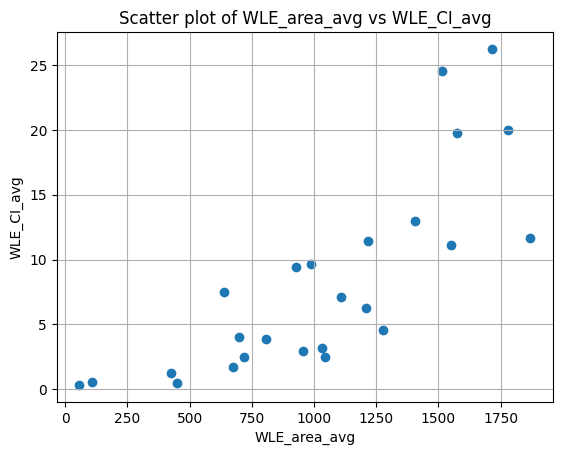

In [17]:
#First glimpse at the Pareto front with existing data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Importing the dataset from Ho & Michalak (2017) containing objective function values and the corresponding design variables
data=pd.read_excel(r"C:\Users\gotta\OneDrive\Documents\Bureau\X\4A\US\Stanford\Classes\AA 222\Final Project\Data\Dataset.xlsx", engine='openpyxl') 
data=pd.DataFrame(data)
X=data[['9year_cum','aprjul']]
X=np.array(X)

A=data['WLE_area_avg']

CI=data['WLE_CI_avg']
plt.scatter(A,CI)
plt.xlabel('WLE_area_avg')
plt.ylabel('WLE_CI_avg')
plt.title('Scatter plot of WLE_area_avg vs WLE_CI_avg')
plt.grid()
plt.show()

First let's sample a high number of DRP values 1000x1000 in the trust region

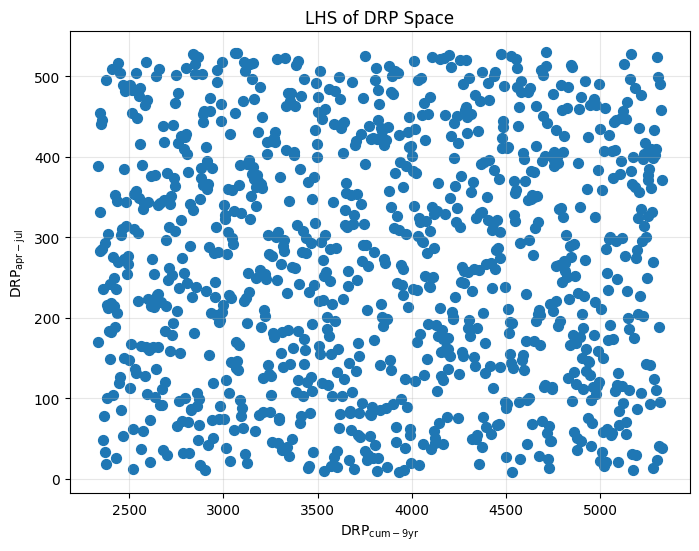

In [2]:
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt

# Define parameter bounds
lower_bounds = [2335, 8]  # Lower bounds for cumulative_DRP and springtime_DRP
upper_bounds = [5328, 530]  # Upper bounds (adjust based on your domain knowledge)

# Generate LHS samples (20 points in 2D space)
lhs_samples = lhs(2, samples=1000, criterion='maximin')

# Scale samples to your actual parameter ranges
scaled_samples = lower_bounds + lhs_samples * (np.array(upper_bounds) - np.array(lower_bounds))

# Visualize the sampling
plt.figure(figsize=(8, 6))
plt.scatter(scaled_samples[:, 0], scaled_samples[:, 1], s=50)
plt.xlabel(r'$\mathrm{DRP_{cum-9yr}}$')
plt.ylabel(r'$\mathrm{DRP_{apr-jul}}$')
plt.title('LHS of DRP Space')
plt.grid(True, alpha=0.3)
plt.show()

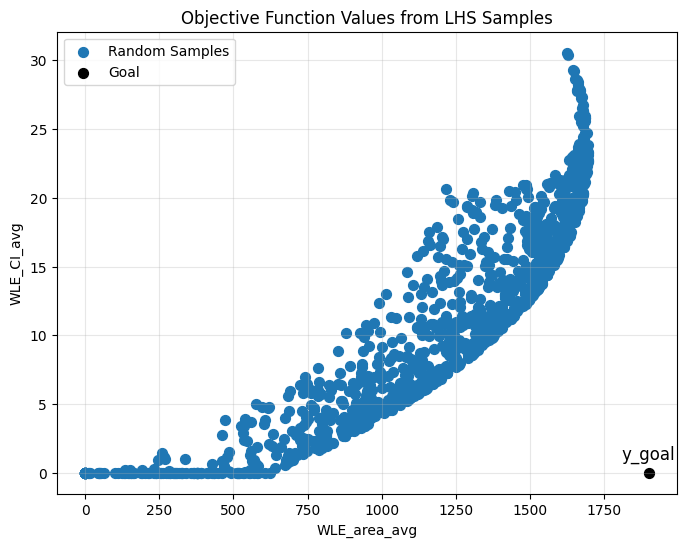

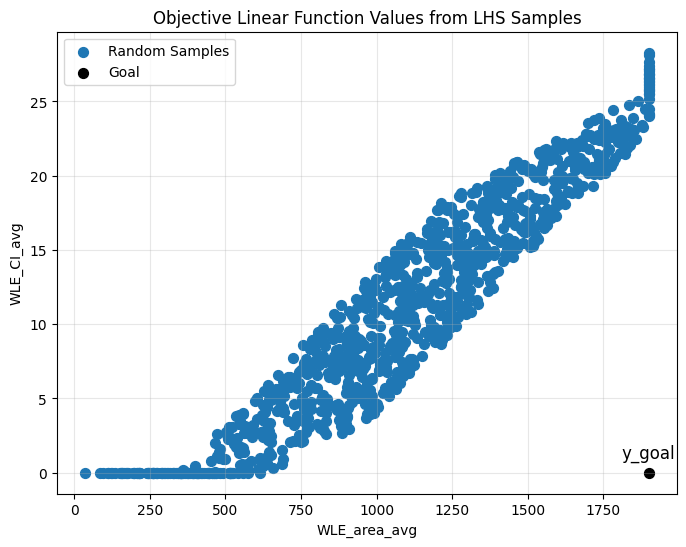

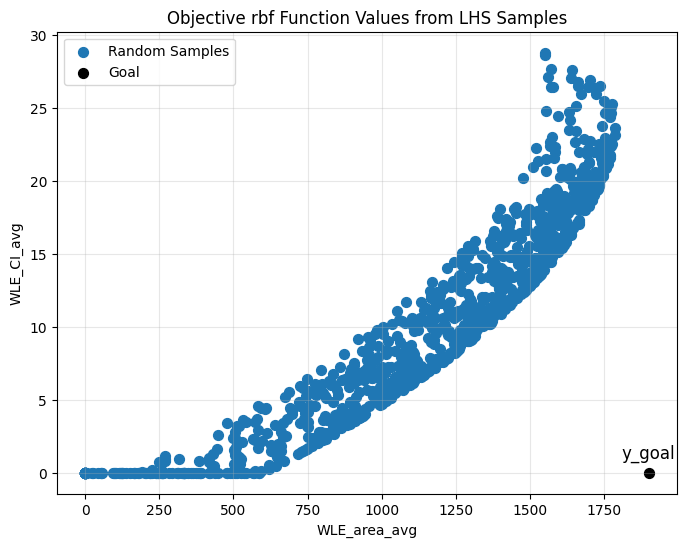

In [19]:
#We define here the vecotirized function to be minimized that takes the linear models
def f(X):
    # Extract the design variables
    cumulative_DRP = X[0]
    springtime_DRP = X[1]

    # Calculate the objective function values
    WLE_area_avg = 1.15932573e+00 *cumulative_DRP+ 7.33376654e+00*springtime_DRP -9.71725717e-05*cumulative_DRP**2-5.27110541e-04*cumulative_DRP*springtime_DRP-5.19438894e-03*springtime_DRP**2-2742.27690937
    WLE_CI_avg = -7.66300341e-03*cumulative_DRP+ 4.43048133e-02*springtime_DRP+  1.48037048e-06*cumulative_DRP**2-5.26642163e-07*cumulative_DRP*springtime_DRP+ 1.20878145e-05*springtime_DRP**2+4.560071263812404
    if WLE_area_avg < 0:
        WLE_area_avg = 0

    if WLE_CI_avg < 0:
        WLE_CI_avg = 0
    return [WLE_area_avg, WLE_CI_avg]
def f_linear(X):
    # Extract the design variables
    cumulative_DRP = X[0]
    springtime_DRP = X[1]

    # Calculate the objective function values
    WLE_area_avg =  0.31838624*cumulative_DRP+ 2.29792759*springtime_DRP-742.21898475
    WLE_CI_avg=0.00348731*cumulative_DRP+ 0.04818059*springtime_DRP -15.344444752266575
    if WLE_area_avg < 0:
        WLE_area_avg = 0
    if WLE_area_avg>1900:
        WLE_area_avg = 1900
    if WLE_CI_avg < 0:
        WLE_CI_avg = 0
    return [WLE_area_avg, WLE_CI_avg]
# Apply the function to the LHS samples
objective_values = np.array([f(sample) for sample in scaled_samples])
objective_values_linear = np.array([f_linear(sample) for sample in scaled_samples])
plt.figure(figsize=(8, 6))
plt.scatter(objective_values[:, 0], objective_values[:, 1], s=50, label='Random Samples')
plt.scatter(1900,0, c='black', s=50, label='Goal')  # Goal point
plt.text(1900, 1, 'y_goal', fontsize=12, ha='center', color='black')  # Adjust y-coordinate as needed
plt.xlabel('WLE_area_avg')
plt.ylabel('WLE_CI_avg')
plt.legend()
plt.title('Objective Function Values from LHS Samples')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(objective_values_linear[:, 0], objective_values_linear[:, 1], s=50, label='Random Samples')
plt.scatter(1900,0, c='black', s=50, label='Goal')  # Goal point
plt.text(1900, 1, 'y_goal', fontsize=12, ha='center', color='black')  # Adjust y-coordinate as needed
plt.xlabel('WLE_area_avg')
plt.ylabel('WLE_CI_avg')
plt.legend()
plt.title('Objective Linear Function Values from LHS Samples')
plt.grid(True, alpha=0.3)
plt.show()
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator

rbf_A = RBFInterpolator(X, A, kernel='gaussian',epsilon=0.0001232846739442066,smoothing= 1.519911082952933e-06)
rbf_CI = RBFInterpolator(X, CI, kernel='multiquadric',epsilon=6.579332246575683e-05,smoothing= 6.579332246575683e-05)
def f_rbf(X):
    # Calculate the objective function values
    WLE_area_avg = rbf_A(X)
    WLE_CI_avg = rbf_CI(X)
    WLE_area_avg = np.maximum(0, WLE_area_avg)  # Replace negatives with zero
    WLE_CI_avg = np.maximum(0, WLE_CI_avg) 
    return np.column_stack([WLE_area_avg, WLE_CI_avg])
# Apply the function to the LHS samples

objective_values_rbf = f_rbf(scaled_samples)
plt.figure(figsize=(8, 6))
plt.scatter(objective_values_rbf[:, 0], objective_values_rbf[:, 1], s=50, label='Random Samples')
plt.scatter(1900,0, c='black', s=50, label='Goal')  # Goal point
plt.text(1900, 1, 'y_goal', fontsize=12, ha='center', color='black')  # Adjust y-coordinate as needed
plt.xlabel('WLE_area_avg')
plt.ylabel('WLE_CI_avg')
plt.legend()
plt.title('Objective rbf Function Values from LHS Samples')
plt.grid(True, alpha=0.3)
plt.show()
    

The goal here is to plot the Pareto front using a GA (see section 15.4 in the textbook). We will first define the selection, crossover and mutation methods

In [20]:
def dominates(y, y_prime):
    """
    Check if vector y dominates vector y_prime.
    
    Parameters:
    y : list or array-like
        A vector of objective values.
    y_prime : list or array-like
        Another vector of objective values.
    
    Returns:
    bool
        True if y dominates y_prime, False otherwise.
    """
    # Maximize the first objective (y[0]) and minimize the second objective (y[1])
    return (y[0] >= y_prime[0] and y[1] <= y_prime[1]) and \
           (y[0] > y_prime[0] or y[1] < y_prime[1])

def non_dominated_points(objective_values):
    """
    Find non-dominated points in the objective space.
    
    Parameters:
    objective_values : array-like
        An array of objective function values.
    """
    non_dominated = []
    n_samples = len(objective_values)
    
    for i in range(n_samples):
        is_dominated = False
        for j in range(n_samples):
            if i != j:
                # Check if objective_values[j] dominates objective_values[i]
                if dominates(objective_values[j], objective_values[i]):
                    is_dominated = True
                    break
        if not is_dominated:
            non_dominated.append(objective_values[i])
    
    return np.array(non_dominated)


non_dom_pt = non_dominated_points(objective_values)


Linear fit: CI = 0.0197 * Area + -14.3590


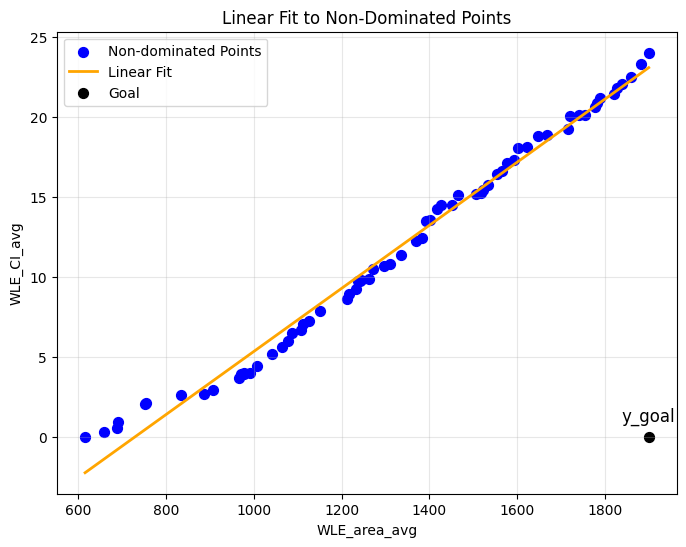

In [21]:
# Fit the non-dominated points with a linear curve

from scipy.stats import linregress

# Extract non-dominated points
non_dom_pt_linear = non_dominated_points(objective_values_linear)

# Separate x (Area) and y (CI)
x_data = non_dom_pt_linear[:, 0]
y_data = non_dom_pt_linear[:, 1]

# Fit a linear regression: y = m*x + c
slope, intercept, r_value, p_value, std_err = linregress(x_data, y_data)
print(f"Linear fit: CI = {slope:.4f} * Area + {intercept:.4f}")

# Generate fit line for plotting
x_fit = np.linspace(np.min(x_data), np.max(x_data), 100)
y_fit = slope * x_fit + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, s=50, label='Non-dominated Points', color='blue')
plt.plot(x_fit, y_fit, color='orange', linewidth=2, label='Linear Fit')
plt.scatter(1900, 0, c='black', s=50, label='Goal')
plt.text(1900, 1, 'y_goal', fontsize=12, ha='center', color='black')
plt.xlabel('WLE_area_avg')
plt.ylabel('WLE_CI_avg')
plt.legend()
plt.title('Linear Fit to Non-Dominated Points')
plt.grid(True, alpha=0.3)
plt.show()

Fitted parameters: a=1.5558691048790139, b=2.602852300981906, c=2.114225565812434e-19


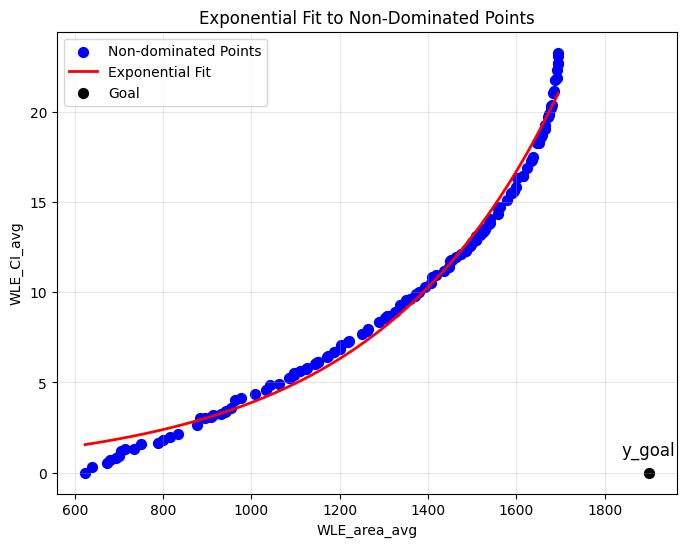

In [22]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the exponential function
def exponential_func(x, a, b, c):
    return a * np.exp(b * x) + c

# Extract the non-dominated points
non_dom_pt = non_dominated_points(objective_values)

# Separate the x and y values
x_data = non_dom_pt[:, 0]  # First objective (e.g., WLE_area_avg)
y_data = non_dom_pt[:, 1]  # Second objective (e.g., WLE_CI_avg)

# Normalize the x_data to prevent overflow
x_data_normalized = (x_data - np.min(x_data)) / (np.max(x_data) - np.min(x_data))

# Fit the exponential function to the normalized data with bounds
popt, pcov = curve_fit(
    exponential_func,
    x_data_normalized,
    y_data,
    bounds=([0, -np.inf, 0], [np.inf, np.inf, np.inf])  # Restrict parameters to positive values
)

# Extract the fitted parameters
a, b, c = popt
print(f"Fitted parameters: a={a}, b={b}, c={c}")

# Generate x values for the fitted curve
x_fit_normalized = np.linspace(0, 1, 500)
y_fit = exponential_func(x_fit_normalized, a, b, c)

# Denormalize x_fit for plotting
x_fit = x_fit_normalized * (np.max(x_data) - np.min(x_data)) + np.min(x_data)

# Plot the non-dominated points and the fitted curve
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, s=50, label='Non-dominated Points', color='blue')
plt.plot(x_fit, y_fit, label='Exponential Fit', color='red', linewidth=2)
plt.scatter(1900, 0, c='black', s=50, label='Goal')  # Goal point
plt.text(1900, 1, 'y_goal', fontsize=12, ha='center', color='black')  # Adjust y-coordinate as needed
plt.xlabel('WLE_area_avg')
plt.ylabel('WLE_CI_avg')
plt.legend()
plt.title('Exponential Fit to Non-Dominated Points')
plt.grid(True, alpha=0.3)
plt.show()

Fitted parameters: a=2.143338928610597, b=2.3436488930559842, c=1.6814662535687988e-19


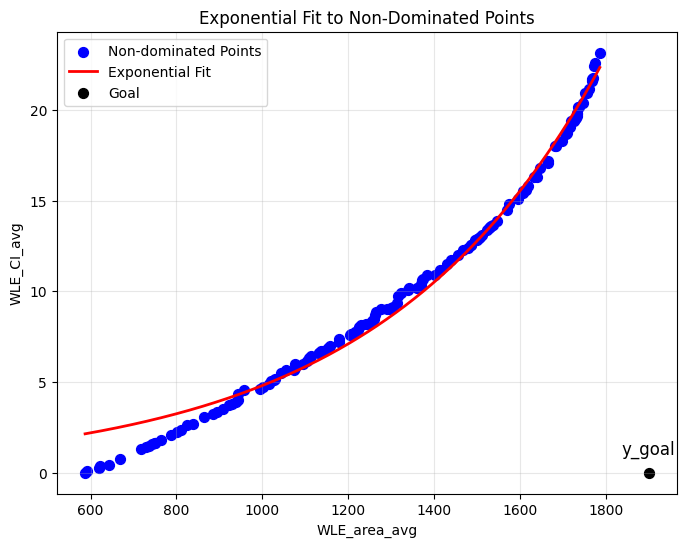

In [23]:

from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the exponential function
def exponential_func(x, a, b, c):
    return a * np.exp(b * x) + c

# Extract the non-dominated points
non_dom_pt_rbf = non_dominated_points(objective_values_rbf)

# Separate the x and y values
x_data = non_dom_pt_rbf[:, 0]  # First objective (e.g., WLE_area_avg)
y_data = non_dom_pt_rbf[:, 1]  # Second objective (e.g., WLE_CI_avg)

# Normalize the x_data to prevent overflow
x_data_normalized = (x_data - np.min(x_data)) / (np.max(x_data) - np.min(x_data))

# Fit the exponential function to the normalized data with bounds
popt, pcov = curve_fit(
    exponential_func,
    x_data_normalized,
    y_data,
    bounds=([0, -np.inf, 0], [np.inf, np.inf, np.inf])  # Restrict parameters to positive values
)

# Extract the fitted parameters
a, b, c = popt
print(f"Fitted parameters: a={a}, b={b}, c={c}")

# Generate x values for the fitted curve
x_fit_normalized = np.linspace(0, 1, 500)
y_fit = exponential_func(x_fit_normalized, a, b, c)

# Denormalize x_fit for plotting
x_fit = x_fit_normalized * (np.max(x_data) - np.min(x_data)) + np.min(x_data)

# Plot the non-dominated points and the fitted curve
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, s=50, label='Non-dominated Points', color='blue')
plt.plot(x_fit, y_fit, label='Exponential Fit', color='red', linewidth=2)
plt.scatter(1900, 0, c='black', s=50, label='Goal')  # Goal point
plt.text(1900, 1, 'y_goal', fontsize=12, ha='center', color='black')  # Adjust y-coordinate as needed
plt.xlabel('WLE_area_avg')
plt.ylabel('WLE_CI_avg')
plt.legend()
plt.title('Exponential Fit to Non-Dominated Points')
plt.grid(True, alpha=0.3)
plt.show()
    

Now what can be interesting is plotting a 'made-up' final Pareto frontier weighting each contribution, based on their RMSE

w_lin: [0.34545394 0.33716242], w_poly: [0.32374342 0.33073793], w_rbf: [0.33080264 0.33209964]
Fitted parameters: a=2.0563795986145132, b=2.5084178102007875, c=4.0539815053021915e-15


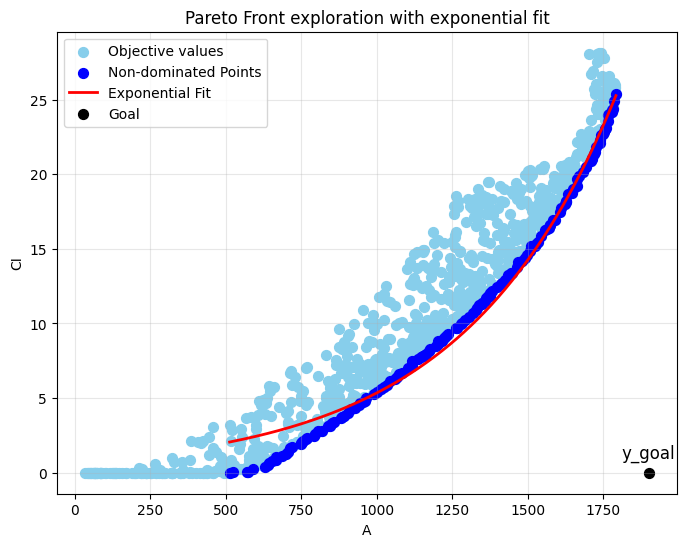

In [37]:
RMSE_lin_A = 198.70777123358948
RMSE_poly_A = 212.0332907234296
RMSE_rbf_A = 207.50857142003355
RMSE_lin_C = 3.465323671664375
RMSE_poly_C = 3.5326365680152736
RMSE_rbf_C = 3.5181516846434926
w_lin_A = (1/RMSE_lin_A)/(1/RMSE_lin_A + 1/RMSE_poly_A + 1/RMSE_rbf_A)
w_poly_A = (1/RMSE_poly_A)/(1/RMSE_lin_A + 1/RMSE_poly_A + 1/RMSE_rbf_A)
w_rbf_A = (1/RMSE_rbf_A)/(1/RMSE_lin_A + 1/RMSE_poly_A + 1/RMSE_rbf_A)
w_lin_C = (1/RMSE_lin_C)/(1/RMSE_lin_C + 1/RMSE_poly_C + 1/RMSE_rbf_C)
w_poly_C = (1/RMSE_poly_C)/(1/RMSE_lin_C + 1/RMSE_poly_C + 1/RMSE_rbf_C)
w_rbf_C = (1/RMSE_rbf_C)/(1/RMSE_lin_C + 1/RMSE_poly_C + 1/RMSE_rbf_C)

w_lin=np.array([w_lin_A,w_lin_C])
w_poly=np.array([w_poly_A,w_poly_C])
w_rbf=np.array([w_rbf_A,w_rbf_C])
print(f"w_lin: {w_lin}, w_poly: {w_poly}, w_rbf: {w_rbf}")
def f_vector(X):
    # X shape: (n_samples, 2)
    cumulative_DRP = X[:, 0]
    springtime_DRP = X[:, 1]
    WLE_area_avg = (
        1.15932573e+00 * cumulative_DRP
        + 7.33376654e+00 * springtime_DRP
        - 9.71725717e-05 * cumulative_DRP**2
        - 5.27110541e-04 * cumulative_DRP * springtime_DRP
        - 5.19438894e-03 * springtime_DRP**2
        - 2742.27690937
    )
    WLE_CI_avg = (
        -7.66300341e-03 * cumulative_DRP
        + 4.43048133e-02 * springtime_DRP
        + 1.48037048e-06 * cumulative_DRP**2
        - 5.26642163e-07 * cumulative_DRP * springtime_DRP
        + 1.20878145e-05 * springtime_DRP**2
        + 4.560071263812404
    )
    WLE_area_avg = np.maximum(0, WLE_area_avg)
    WLE_CI_avg = np.maximum(0, WLE_CI_avg)
    return np.column_stack([WLE_area_avg, WLE_CI_avg])
def f_linear_vector(X):
    # X shape: (n_samples, 2)
    cumulative_DRP = X[:, 0]
    springtime_DRP = X[:, 1]
    WLE_area_avg = 0.31838624 * cumulative_DRP + 2.29792759 * springtime_DRP - 742.21898475
    WLE_CI_avg = 0.00348731 * cumulative_DRP + 0.04818059 * springtime_DRP - 15.344444752266575
    WLE_area_avg = np.clip(WLE_area_avg, 0, 1900)
    WLE_CI_avg = np.maximum(0, WLE_CI_avg)
    return np.column_stack([WLE_area_avg, WLE_CI_avg])



# Compute predictions from each model
y_linear0 = f_linear_vector(scaled_samples)  # shape (n_samples, 2)
y_poly0 = f_vector(scaled_samples)           # shape (n_samples, 2)
y_rbf0 = f_rbf(scaled_samples)               # shape (n_samples, 2)

# Stack into shape (n_samples, 2, 3): 3 models
y_all = np.stack([y_linear0, y_poly0, y_rbf0], axis=-1)  # shape (n_samples, 2, 3)

# Stack weights into shape (2, 3): 2 objectives, 3 models
weights = np.stack([w_lin, w_poly, w_rbf], axis=-1)   # shape (2, 3)

# Weighted sum across models for each objective
y_madeup = np.einsum('nij,ij->ni', y_all, weights)    # shape (n_samples, 2)



non_dom_madeup = non_dominated_points(y_madeup)  # Just the 2D outputs
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the exponential function
def exponential_func(x, a, b, c):
    return a * np.exp(b * x) + c


# Separate the x and y values
x_data = non_dom_madeup[:, 0]  # First objective (e.g., WLE_area_avg)
y_data = non_dom_madeup[:, 1]  # Second objective (e.g., WLE_CI_avg)

# Normalize the x_data to prevent overflow
x_data_normalized = (x_data - np.min(x_data)) / (np.max(x_data) - np.min(x_data))

# Fit the exponential function to the normalized data with bounds
popt, pcov = curve_fit(
    exponential_func,
    x_data_normalized,
    y_data,
    bounds=([0, -np.inf, 0], [np.inf, np.inf, np.inf])  # Restrict parameters to positive values
)

# Extract the fitted parameters
a, b, c = popt
print(f"Fitted parameters: a={a}, b={b}, c={c}")

# Generate x values for the fitted curve
x_fit_normalized = np.linspace(0, 1, 500)
y_fit = exponential_func(x_fit_normalized, a, b, c)

# Denormalize x_fit for plotting
x_fit = x_fit_normalized * (np.max(x_data) - np.min(x_data)) + np.min(x_data)

# Plot the non-dominated points and the fitted curve
plt.figure(figsize=(8, 6))
plt.scatter(y_madeup[:, 0], y_madeup[:, 1], s=50, label='Objective values', color='skyblue')
plt.scatter(x_data, y_data, s=50, label='Non-dominated Points', color='blue')
plt.plot(x_fit, y_fit, label='Exponential Fit', color='red', linewidth=2)
plt.scatter(1900, 0, c='black', s=50, label='Goal')  # Goal point
plt.text(1900, 1, 'y_goal', fontsize=12, ha='center', color='black')  # Adjust y-coordinate as needed
plt.xlabel('A')
plt.ylabel('CI')
plt.legend()
plt.title('Pareto Front exploration with exponential fit')
plt.grid(True, alpha=0.3)
plt.show()


In [25]:
#Selection method 

import numpy as np
from numpy.random import default_rng

# Abstract base class for selection methods
class SelectionMethod:
    def select(self, fitness_values):
        raise NotImplementedError("Subclasses should implement this!")

# Truncation Selection
class TruncationSelection(SelectionMethod):
    def __init__(self, k):
        self.k = k

    def select(self, fitness_values):
        # Get the indices of the top k individuals
        top_k_indices = np.argsort(fitness_values)[:self.k]
        # Randomly pick pairs from the top k
        rng = default_rng()
        return [rng.choice(top_k_indices, size=2, replace=True) for _ in fitness_values]

# Tournament Selection
class TournamentSelection(SelectionMethod):
    def __init__(self, k):
        self.k = k

    def select(self, fitness_values):
        n = len(fitness_values)
        rng = default_rng()

        def get_parent():
            # Randomly pick k individuals and select the one with the lowest fitness
            candidates = rng.choice(n, size=self.k, replace=False)
            return candidates[np.argmin(fitness_values[candidates])]

        return [[get_parent(), get_parent()] for _ in fitness_values]

# Roulette Wheel Selection
class RouletteWheelSelection(SelectionMethod):
    def select(self, fitness_values):
        # Convert to maximization problem by inverting fitness
        adjusted_fitness = np.max(fitness_values) - fitness_values
        # Normalize to create probabilities
        probabilities = adjusted_fitness / np.sum(adjusted_fitness)
        rng = default_rng()
        # Sample pairs based on these probabilities
        return [rng.choice(len(fitness_values), size=2, p=probabilities) for _ in fitness_values]

# Example usage
fitness_values = np.array([10, 20, 15, 30, 25])
#Returns the indices of the selected individuals
trunc_sel = TruncationSelection(k=3)
print("Truncation Selection:", trunc_sel.select(fitness_values))

tourn_sel = TournamentSelection(k=3)
print("Tournament Selection:", tourn_sel.select(fitness_values))

rw_sel = RouletteWheelSelection()
print("Roulette Wheel Selection:", rw_sel.select(fitness_values))


Truncation Selection: [array([2, 1]), array([0, 1]), array([1, 1]), array([1, 2]), array([1, 0])]
Tournament Selection: [[np.int64(1), np.int64(0)], [np.int64(0), np.int64(0)], [np.int64(1), np.int64(0)], [np.int64(0), np.int64(2)], [np.int64(0), np.int64(0)]]
Roulette Wheel Selection: [array([2, 1]), array([1, 0]), array([1, 0]), array([0, 2]), array([0, 1])]


In [26]:
import numpy as np
from numpy.random import default_rng

# Abstract base class for crossover methods
class CrossoverMethod:
    def crossover(self, parent1, parent2):
        raise NotImplementedError("Subclasses should implement this!")

# Single Point Crossover
class SinglePointCrossover(CrossoverMethod):
    def crossover(self, parent1, parent2):
        n = len(parent1)
        i = np.random.randint(1, n)  # pick a random split point
        return np.concatenate((parent1[:i], parent2[i:]))

# Two Point Crossover
class TwoPointCrossover(CrossoverMethod):
    def crossover(self, parent1, parent2):
        n = len(parent1)
        i, j = sorted(np.random.randint(1, n, size=2))
        return np.concatenate((parent1[:i], parent2[i:j], parent1[j:]))

# Uniform Crossover
class UniformCrossover(CrossoverMethod):
    def __init__(self, p=0.5):
        self.p = p

    def crossover(self, parent1, parent2):
        return np.array([u if np.random.rand() > self.p else v 
                         for u, v in zip(parent1, parent2)])

# Interpolation Crossover
class InterpolationCrossover(CrossoverMethod):
    def __init__(self, lam=0.5):
        self.lam = lam

    def crossover(self, parent1, parent2):
        # Linear interpolation
        return (1 - self.lam) * parent1 + self.lam * parent2

# Example usage
rng = default_rng()
parent1 = rng.integers(0, 10, size=5)
parent2 = rng.integers(0, 10, size=5)

print("Parent 1:", parent1)
print("Parent 2:", parent2)

sp_crossover = SinglePointCrossover()
print("Single Point Crossover:", sp_crossover.crossover(parent1, parent2))

tp_crossover = TwoPointCrossover()
print("Two Point Crossover:", tp_crossover.crossover(parent1, parent2))

uc_crossover = UniformCrossover(p=0.5)
print("Uniform Crossover:", uc_crossover.crossover(parent1, parent2))

ic_crossover = InterpolationCrossover(lam=0.3)
print("Interpolation Crossover:", ic_crossover.crossover(parent1, parent2))


Parent 1: [2 0 2 7 2]
Parent 2: [8 5 5 3 8]
Single Point Crossover: [2 0 2 7 8]
Two Point Crossover: [2 5 2 7 2]
Uniform Crossover: [8 0 5 3 8]
Interpolation Crossover: [3.8 1.5 2.9 5.8 3.8]


In [27]:
import numpy as np
from numpy.random import default_rng

# Abstract base class for mutation methods
class MutationMethod:
    def mutate(self, child):
        raise NotImplementedError("Subclasses should implement this!")

# Distribution Mutation
class DistributionMutation(MutationMethod):
    def __init__(self, lam, distribution):
        self.lam = lam  # Mutation rate (probability of mutating each gene)
        self.distribution = distribution

    def mutate(self, child):
        rng = default_rng()
        # Apply mutation with probability λ to each gene
        return np.array([
            v + rng.choice(self.distribution) if rng.random() < self.lam else v 
            for v in child
        ])

# Bounded Gaussian Mutation
# Improved Gaussian Mutation with bounds and different sigmas for each variable
class GaussianMutation(MutationMethod):
    def __init__(self, sigmas, lam=0.3, lower_bounds=None, upper_bounds=None):
        self.sigmas = sigmas  # e.g., [100, 1]
        self.lam = lam
        self.lower_bounds = lower_bounds if lower_bounds is not None else [2335, 8]
        self.upper_bounds = upper_bounds if upper_bounds is not None else [5328, 530]
        self.rng = default_rng()
    def mutate(self, child):
        mutated_child = child.copy()
        for i in range(len(child)):
            if self.rng.random() < self.lam:
                mutation = self.rng.normal(0, self.sigmas[i])
                mutated_value = child[i] + mutation
                # Bound the value
                mutated_value = max(self.lower_bounds[i], min(self.upper_bounds[i], mutated_value))
                mutated_child[i] = mutated_value
        return mutated_child
rng = default_rng()
child = rng.integers(0, 10, size=5)

print("Original Child:", child)

# Example with uniform distribution
uniform_mutation = DistributionMutation(lam=0.5, distribution=np.arange(-3, 4))
print("Uniform Mutation:", uniform_mutation.mutate(child))

# # Example with Gaussian distribution
# gaussian_mutation = GaussianMutation(sigmas=[1.0,1.0], lam=0.5)
# print("Gaussian Mutation:", gaussian_mutation.mutate(child))


Original Child: [0 5 8 4 9]
Uniform Mutation: [0 7 7 4 9]


In [28]:
import numpy as np

def non_dominated_sort(objective_values):
    """
    Perform non-dominated sorting on a set of objective values.
    Returns a list of fronts, each front is a list of indices.
    """
    n = len(objective_values)
    S = [[] for _ in range(n)]  # Solutions each solution dominates
    n_dom = np.zeros(n, dtype=int)  # Number of solutions that dominate each solution
    fronts = [[]]

    for p in range(n):
        for q in range(n):
            if p == q:
                continue
            if dominates(objective_values[p], objective_values[q]):
                S[p].append(q)
            elif dominates(objective_values[q], objective_values[p]):
                n_dom[p] += 1
        if n_dom[p] == 0:
            fronts[0].append(p)

    i = 0
    while len(fronts[i]) > 0:
        next_front = []
        for p in fronts[i]:
            for q in S[p]:
                n_dom[q] -= 1
                if n_dom[q] == 0:
                    next_front.append(q)
        i += 1
        fronts.append(next_front)
    # Remove the last empty front
    if len(fronts[-1]) == 0:
        fronts.pop()
    return fronts

# ---------- Fitness Sharing in Objective Space ----------
def fitness_sharing(objectives, sigma_share):
    """
    Fitness sharing using a Gaussian kernel in normalized objective space.
    """
    n = len(objectives)
    shared_fitness = np.ones(n)
    objectives = np.array(objectives)
    # Normalize objectives to [0, 1] along each axis
    mins = objectives.min(axis=0)
    maxs = objectives.max(axis=0)
    ranges = maxs - mins
    ranges[ranges == 0] = 1  # Avoid division by zero
    norm_obj = (objectives - mins) / ranges

    for i in range(n):
        niche_count = 0
        for j in range(n):
            d = np.linalg.norm(norm_obj[i] - norm_obj[j])
            # Gaussian kernel for sharing
            sh = np.exp(-0.5 * (d / sigma_share) ** 2)
            niche_count += sh
        shared_fitness[i] = 1.0 / niche_count if niche_count > 0 else 1.0
    return shared_fitness
# ---------- VEGA with Fitness Sharing ----------
def vector_evaluated_genetic_algorithm(f, population, k_max, S, C, M, sigma_share=0.1):
    """
    Vector-evaluated Genetic Algorithm with Pareto sorting and fitness sharing
    Args:
        f: vector-valued objective function f(x) -> list or array
        population: list of candidate solutions (decision variables)
        k_max: number of iterations
        S: selection function: takes fitness values, returns indices of selected parents
        C: crossover function: combines two parents to create a child
        M: mutation function: applies mutation to an individual
        sigma_share: sharing distance for fitness sharing (in objective space)
    """
    m_pop = len(population)

    for k in range(k_max):
        # Step 1: Evaluate population in objective space
        ys = np.array([f(ind) for ind in population])

        # Step 2: Non-dominated sorting
        fronts = non_dominated_sort(ys)
        new_population = []

        for front in fronts:
            if len(new_population) >= m_pop:
                break

            front_objs = ys[front]
            shared_fitness = fitness_sharing(front_objs, sigma_share=sigma_share)
            parent_indices = S(shared_fitness)

            for pair in parent_indices:
                i1, i2 = pair  # unpack the tuple
                parent1 = population[front[i1]]
                parent2 = population[front[i2]]
                child = M(C(parent1, parent2))
                new_population.append(child)
                if len(new_population) >= m_pop:
                    break

        # Fill the rest with best elites if necessary
        if len(new_population) < m_pop:
            elites = [population[i] for i in fronts[0]]
            while len(new_population) < m_pop:
                new_population.append(elites[len(new_population) % len(elites)])

        population = new_population

    return population

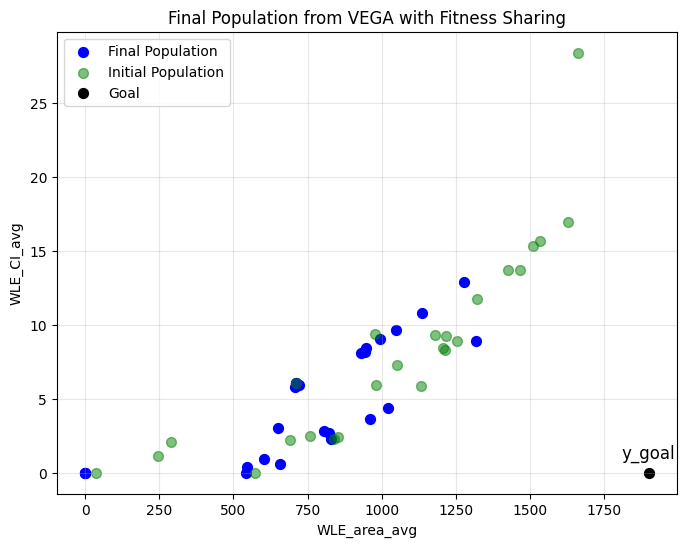

In [29]:
# Define initial population from data
initial_population = [np.array([X[k,0], X[k,1]]) for k in range(len(X))]

# Use the improved mutation in your GA run
final_pop = vector_evaluated_genetic_algorithm(f,
    population=initial_population,
    k_max=100,
    S=TruncationSelection(k=5).select,  # Slightly larger k for more selection pressure
    C=SinglePointCrossover().crossover,
    M=GaussianMutation(sigmas=[1000, 100], lam=0.7).mutate,
    sigma_share=1)  # Good value for normalized objectives
# Visualization
plt.figure(figsize=(8, 6))
plt.scatter([f(ind)[0] for ind in final_pop], [f(ind)[1] for ind in final_pop], s=50, label='Final Population', color='blue')
plt.scatter([f(ind)[0] for ind in initial_population], [f(ind)[1] for ind in initial_population], s=50, label='Initial Population', alpha=0.5, color='green')
plt.scatter(1900, 0, c='black', s=50, label='Goal')
plt.text(1900, 1, 'y_goal', fontsize=12, ha='center', color='black')
plt.xlabel('WLE_area_avg')
plt.ylabel('WLE_CI_avg')
plt.legend()
plt.title('Final Population from VEGA with Fitness Sharing')
plt.grid(True, alpha=0.3)
plt.show()
